In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import concurrent.futures

In [2]:
def OMP(A, y, s, noise, n_norm):
    N = A.shape[1]
    M = A.shape[0]
    k = []                           
    a = np.empty((M, 0))  
    r = y                            

    while max(np.abs(A.T @ r)) > 0.1:
        x_omp = np.zeros((N, 1))
        j = np.argmax(np.abs(A.T @ r))
        k.append(j)

        a = np.hstack([a, A[:, j].reshape(M, 1)])

        a_temp = np.linalg.inv(a.T @ a)
        alpha = a_temp @ a.T @ y
        b = a @ alpha
        r = y - b

        for i in range(len(k)):
            x_omp[k[i], 0] = alpha[i]
        error = np.linalg.norm(y - A @ x_omp)

        if noise:
            if error < n_norm or len(k) == s:
                break
        else:
            if error < 1e-3:
                break

    for i in range(len(k)):
        x_omp[k[i], 0] = alpha[i]

    return x_omp, len(k)


In [3]:
import numpy as np
import random
import concurrent.futures

def parallel_monte_carlo(N, s_max, A_normal_upper, sigma):
    def monte_carlo_simulation(M, s, N, A_normal_upper, sigma, mc_time=2000):
        success, success_large = 0, 0
        avg_error, avg_error_large = 0, 0
        for iter in range(mc_time):
            print(f"Processing m={M}, s={s}, iteration={iter+1}/{mc_time}")

            A = np.random.normal(0, A_normal_upper, (M, N))
            A = A / np.linalg.norm(A, axis=0)

            x = np.zeros((N, 1))

            j = random.sample(range(N), s)
            x[j] = random.randint(-10, 10)
            while sum(x[j] == 0):
                x[j] = random.randint(-10, 10)

            n = np.random.normal(0, sigma[0], (M, 1))
            n_large = np.random.normal(0, sigma[1], (M, 1))

            y = ((A @ x) + n)
            y_large = ((A @ x) + n_large)
            x_omp, _ = OMP(A, y, 0, True, np.linalg.norm(n))
            x_omp_large, _ = OMP(A, y_large, 0, True, np.linalg.norm(n_large))
            error = np.linalg.norm(x - x_omp) / np.linalg.norm(x)
            error_large = np.linalg.norm(x - x_omp_large) / np.linalg.norm(x)

            avg_error += error
            avg_error_large += error_large

            if error < 1e-3:
                success += 1
            if error_large < 1e-3:
                success_large += 1

        return success / mc_time, success_large / mc_time, avg_error / mc_time, avg_error_large / mc_time

    success_plot, success_plot_large, avg_error_plot, avg_error_plot_large = [], [], [], []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = {}
        for M in range(1, N):
            for s in range(1, s_max):
                future = executor.submit(monte_carlo_simulation, M, s, N, A_normal_upper, sigma)
                futures[future] = (M, s)

        for future in concurrent.futures.as_completed(futures):
            M, s = futures[future]
            success, success_large, avg_error, avg_error_large = future.result()

            while len(success_plot) <= M:
                success_plot.append([])
                success_plot_large.append([])
                avg_error_plot.append([])
                avg_error_plot_large.append([])

            success_plot[M - 1].append(success)
            success_plot_large[M - 1].append(success_large)
            avg_error_plot[M - 1].append(avg_error)
            avg_error_plot_large[M - 1].append(avg_error_large)

    def pad_and_convert_to_array(list_of_lists):
        max_length = max(len(sublist) for sublist in list_of_lists)
        padded_list = [sublist + [0] * (max_length - len(sublist)) for sublist in list_of_lists]
        return np.array(padded_list, dtype=float)

    success_plot = pad_and_convert_to_array(success_plot)
    success_plot_large = pad_and_convert_to_array(success_plot_large)
    avg_error_plot = pad_and_convert_to_array(avg_error_plot)
    avg_error_plot_large = pad_and_convert_to_array(avg_error_plot_large)


    return success_plot, success_plot_large, avg_error_plot, avg_error_plot_large




In [4]:
N=20
s_max=20
# N=50
# s_max=20
# N = 100
# s_max = 20
A_normal_upper = 1
sigma = [0.1, 10]
success_plot, success_plot_large, avg_error_plot, avg_error_plot_large = parallel_monte_carlo(N, s_max, A_normal_upper, sigma)

Streaming output truncated to the last 5000 lines.
Processing m=19, s=17, iteration=1111/2000Processing m=19, s=19, iteration=353/2000
Processing m=19, s=16, iteration=1253/2000Processing m=19, s=15, iteration=1649/2000

Processing m=19, s=14, iteration=1912/2000

Processing m=19, s=18, iteration=729/2000Processing m=19, s=17, iteration=1112/2000
Processing m=19, s=14, iteration=1913/2000
Processing m=19, s=15, iteration=1650/2000
Processing m=19, s=19, iteration=354/2000
Processing m=19, s=16, iteration=1254/2000
Processing m=19, s=18, iteration=730/2000

Processing m=19, s=15, iteration=1651/2000
Processing m=19, s=14, iteration=1914/2000Processing m=19, s=16, iteration=1255/2000
Processing m=19, s=19, iteration=355/2000Processing m=19, s=18, iteration=731/2000


Processing m=19, s=16, iteration=1256/2000Processing m=19, s=15, iteration=1652/2000
Processing m=19, s=14, iteration=1915/2000Processing m=19, s=17, iteration=1113/2000Processing m=19, s=18, iteration=732/2000

Processing m

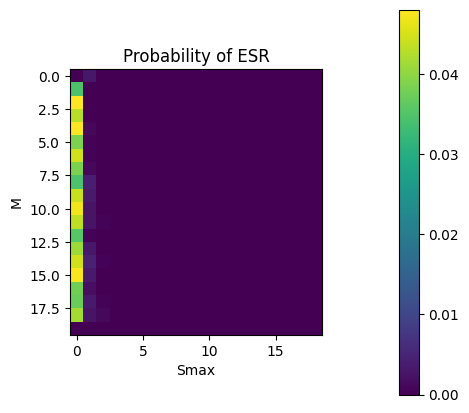

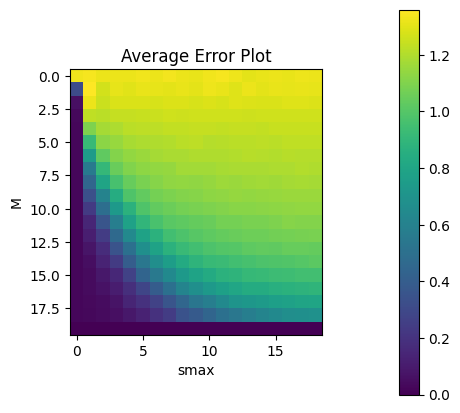

In [5]:
Figure = plt.figure(figsize=(5, 5))
F1 = Figure.add_subplot(1, 1, 1)
ESR = F1.imshow(success_plot)
plt.colorbar(ESR, ax=F1, pad=0.2)
F1.set_xlabel("Smax")
F1.set_ylabel("M")
F1.set_title("Probability of ESR")
plt.savefig('noisy_20_ESR_small_sig(b).png')

Figure = plt.figure(figsize=(5, 5))
F2 = Figure.add_subplot(1, 1,1)
Error = F2.imshow(avg_error_plot)
plt.colorbar(Error, ax=F2, pad=0.2)
F2.set_xlabel("smax")
F2.set_ylabel("M")
F2.set_title("Average Error Plot")
plt.savefig('noisy_20_Err_small_sig(b).png')

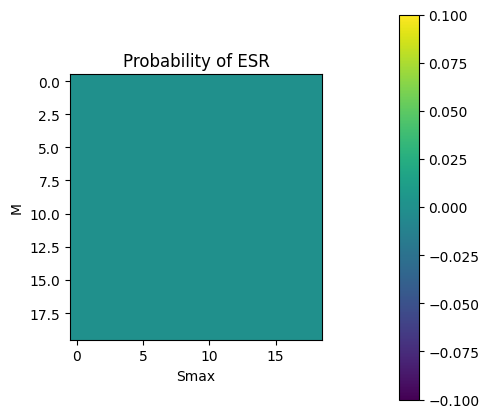

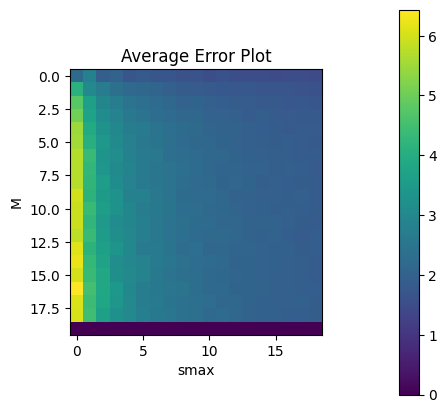

In [6]:
Figure = plt.figure(figsize=(5, 5))
F1 = Figure.add_subplot(1, 1, 1)
ESR = F1.imshow(success_plot_large)
plt.colorbar(ESR, ax=F1, pad=0.2)
F1.set_xlabel("Smax")
F1.set_ylabel("M")
F1.set_title("Probability of ESR")
plt.savefig('noisy_20_ESR_large_sig(b).png')

Figure = plt.figure(figsize=(5, 5))
F2 = Figure.add_subplot(1, 1,1)
Error = F2.imshow(avg_error_plot_large)
plt.colorbar(Error, ax=F2, pad=0.2)
F2.set_xlabel("smax")
F2.set_ylabel("M")
F2.set_title("Average Error Plot")
plt.savefig('noisy_20_Err_large_sig(b).png')